## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

## Load Data

In [3]:
df_housing = pd.read_csv('../scrapers/csv/fotocasa.csv')
df_housing_2023 = pd.read_csv('../scrapers/csv/fotocasa_2023_located_districts.csv')

df_housing.shape, df_housing_2023.shape

((11370, 21), (14130, 19))

## Preprocess

In [4]:
df_housing_2023.columns = df_housing_2023.columns.str.lower()

In [5]:
df_housing_2023['zipcode'] = df_housing_2023['zipcode'].fillna(0)
df_housing_2023['zipcode'] = df_housing_2023['zipcode'].astype(int)
df_housing['zipcode'] = df_housing['zipcode'].fillna(0)
df_housing['zipcode'] = df_housing['zipcode'].astype(int)

In [6]:
df_housing.head()

,address,neighbourhood,district,latitude,longitude,zipcode,date,price,bathrooms,floor,...,heater,elevator,swimming_pool,rooms,surface,conservationState,garden,terrace,balcony,parking
0,"Calle de Julián Rabanedo, Arganzuela",Legazpi,Arganzuela,40.387646,-3.694020,28045,2024-03-22T06:10:33.45Z,375000,1,3,...,1,1,1,2,73,0,0,0,0,0
1,Moncloa - Aravaca,Aravaca,Moncloa - Aravaca,40.462080,-3.774411,28023,2024-03-22T07:05:30.707Z,1200000,4,0,...,1,0,0,4,350,2,1,1,0,0
2,Centro,Cortes - Huertas,Centro,40.410213,-3.696204,28014,2024-03-22T06:20:50.543Z,400000,2,3,...,0,0,0,2,89,1,0,0,0,0
3,"Calle de Almería, Barrio de Salamanca",Fuente del Berro,Barrio de Salamanca,40.430157,-3.662721,28028,2024-03-22T06:51:33.53Z,795000,3,0,...,0,1,0,4,175,3,0,1,0,0
4,Moncloa - Aravaca,La Florida - El Plantío,Moncloa - Aravaca,40.474495,-3.834914,28023,2024-03-22T06:16:21.427Z,860000,4,0,...,0,0,0,6,272,4,1,1,1,0


Going to delete the previous district column because after running the geolocate.py we get better accuracy

In [7]:
df_housing_2023 = df_housing_2023.rename(columns={'district_geolocated': 'district'})

In [8]:
print('Number of properties without price from df_housing: {}'.format(df_housing[df_housing['price'] == 0.0].shape[0]))
print('Number of properties without price from df_housing_2023: {}'.format(df_housing_2023[df_housing_2023['price'] == 0.0].shape[0]))

Number of properties without price from df_housing: 175
Number of properties without price from df_housing_2023: 18


In [9]:
df_housing = df_housing[df_housing['price'] != 0.0] #s(subset=['neighbourhood','district', 'price', 'surface', 'rooms', 'bathrooms', 'zipcode','floor'])
df_housing_2023 = df_housing_2023[df_housing_2023['price'] != 0.0]# (subset=['address', 'price', 'surface', 'rooms', 'bathrooms', 'zipcode','floor'])

In [10]:
set(df_housing.columns) - set(df_housing_2023.columns)

{'conservationState', 'garden'}

Going to see if those {'conservationState', 'garden'} columns are correlated with the price of the property if not we going to remove it 

In [11]:
df_housing['district_encoded'] = le.fit_transform(df_housing['district'])
df_housing['neighbourhood_encoded'] = le.fit_transform(df_housing['neighbourhood'])


## Eda

<Axes: xlabel='date', ylabel='Number of Properties'>

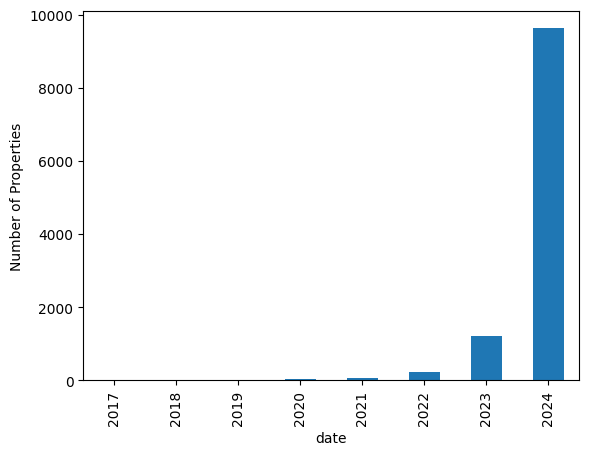

In [12]:
df_housing['date'] = pd.to_datetime(df_housing['date'], format='ISO8601')
ax = df_housing['date'].dt.year.value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Properties')
df_housing['date'].dt.year.value_counts().sort_index().plot(kind='bar')

### Price

In [13]:
df_housing['price'].describe()

count    1.119500e+04
mean     7.783692e+05
std      1.038581e+06
min      1.800000e+04
25%      2.061280e+05
50%      4.355000e+05
75%      8.900000e+05
max      1.400000e+07
Name: price, dtype: float64

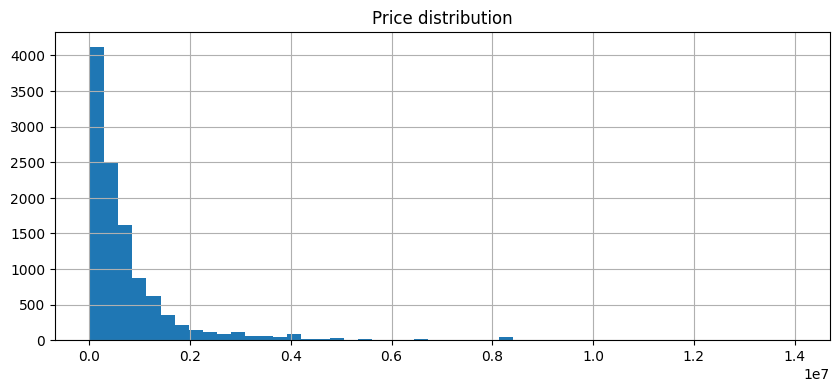

In [14]:
fig = plt.figure(figsize=(10, 4))

plt.title('Price distribution')
df_housing['price'].hist(bins=50)

plt.show()

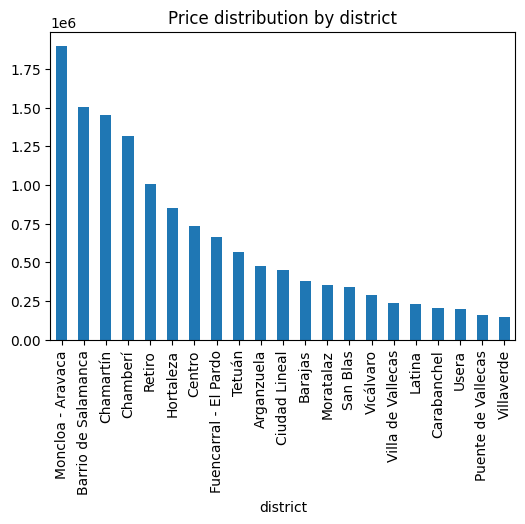

In [15]:
fig = plt.figure(figsize=(6, 4))

plt.title('Price distribution by district')
df_housing.groupby(by='district')['price'].mean().sort_values(ascending=False).plot(kind='bar')
plt.savefig('../figs/price_distribution_by_district.png')
plt.show()

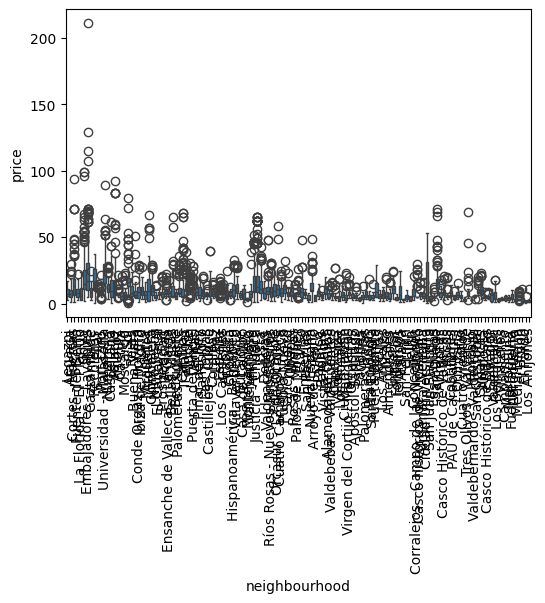

In [16]:
property_count = df_housing.groupby('neighbourhood')['price'].count()

mean_price = df_housing.groupby('neighbourhood')['price'].mean()

normalized_prices = mean_price / property_count.apply(np.sqrt)

df_housing['price'] = df_housing['price'] / df_housing['neighbourhood'].map(normalized_prices)

fig = plt.figure(figsize=(6, 4))
sns.boxplot(x='neighbourhood', y='price', data=df_housing)
plt.xticks(rotation=90)
plt.show()

In [17]:
df_copy = df_housing[df_housing['surface'] != 0.0].reset_index(drop=True)
print(df_copy['surface'].describe())
print(df_housing['price'].describe())

count     11097.000000
mean        367.507074
std       12590.497258
min           1.000000
25%          67.000000
50%          99.000000
75%         150.000000
max      839000.000000
Name: surface, dtype: float64
count    11187.000000
mean        11.891513
std          9.993833
min          0.209662
25%          5.794587
50%          9.007947
75%         14.397619
max        211.089536
Name: price, dtype: float64


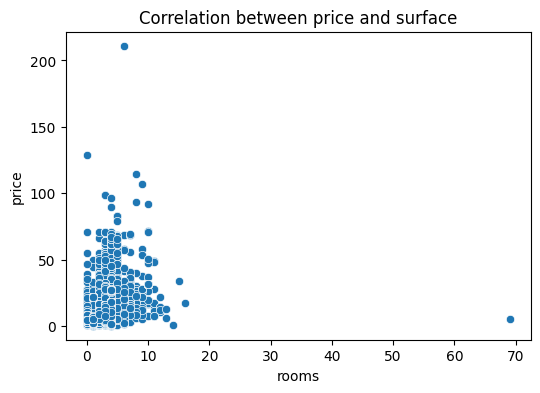

In [18]:

fig = plt.figure(figsize=(6, 4))

plt.title('Correlation between price and surface')
sns.scatterplot(data=df_copy, x='rooms', y='price')

plt.show()

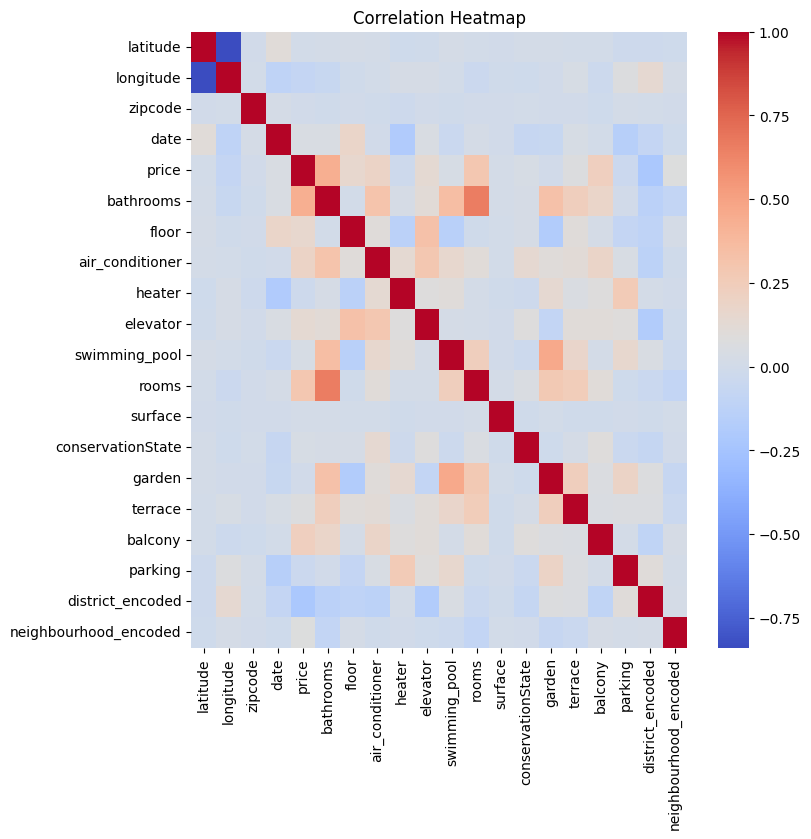

In [19]:
fig = plt.figure(figsize=(8, 8))

correlation_matrix = df_housing.select_dtypes(exclude='object').corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

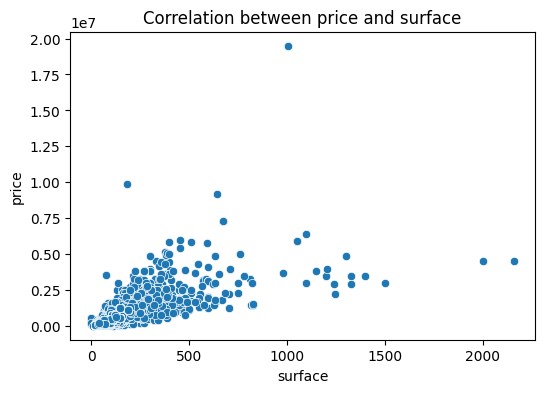

In [20]:
fig = plt.figure(figsize=(6, 4))

plt.title('Correlation between price and surface')
sns.scatterplot(data=df_housing_2023, x='surface', y='price')

plt.show()

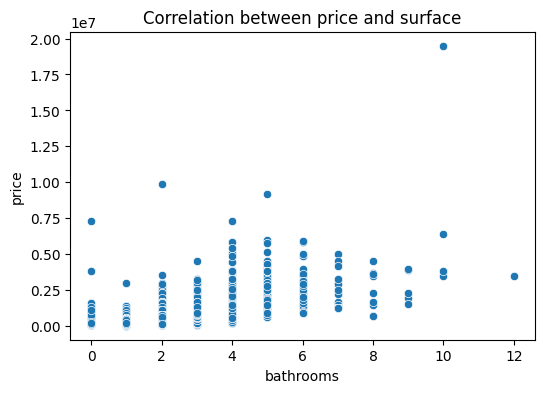

In [21]:
fig = plt.figure(figsize=(6, 4))

plt.title('Correlation between price and surface')
sns.scatterplot(data=df_housing_2023, x='bathrooms', y='price')

plt.show()

In [22]:
df_housing_2023['district_encoded'] = le.fit_transform(df_housing_2023['district'])
df_housing_2023['neighbourhood_encoded'] = le.fit_transform(df_housing_2023['neighbourhood'])
